In [1]:
%matplotlib inline
from sklearn.neighbors import NearestNeighbors, KDTree

from mcmatch import analyze
from mcmatch.db.pg_database import PgFunDB
from mcmatch.util import extract_funname
from mcmatch.feature import all_features, textlength_features, counter_sum_features, counter_features
from mcmatch.feature.aggregator import FeatureAggregator
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import gc


*** feature: counter, fs: False, norm: cityblock
(2981, 66)
(1759, 2981)
514 187 0 2.7486631016


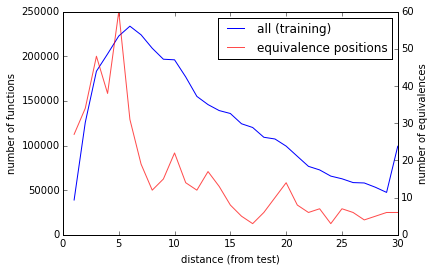

In [4]:

fdb = PgFunDB()
mtm = {
#    'all' : all_features,
#    'textlength' : textlength_features,
    'counter': counter_features,
#    'counter_sum': counter_sum_features
}
# norm = 'cityblock'
#norms = ['euclidean', 'cityblock']
norms = ['cityblock']

#scale_features=[False, True]
scale_features = [False]

train_set = ['t-dietlibc', 't-glibc']
#train_set = ['t-musl']

for mtr_n, norm, scale_feat in product(mtm, norms, scale_features):
    test_repo = 'dietlibc'
    train_name = ",".join(train_set)
    train_name = 'glibc'
    label= 'feature: %s, fs: %r, norm: %s' % (mtr_n, scale_feat, norm)
    print "***", label
    mtr_o = mtm[mtr_n]
    used_features = FeatureAggregator([mtr_o[c]() for c in mtr_o])

    di = analyze.DistanceInfo(fdb, used_features, training_repositories=train_set, scale_features=scale_feat, norm=norm)
    print di.train_data.shape
    pairwise_d, testset_infos = di.test(fdb, in_repositories=['t-musl'])
    print pairwise_d.shape
    training_infos = di.get_trainingset_infos()

    em = analyze.DistanceInfo.make_equivalence_map(testset_infos, training_infos)

    good, bad, other = 0, 0, 0
    for i in range(0, len(em)):
        res = analyze.DistanceInfo.get_partition_sizes(pairwise_d[i], None, em[i])
        for el in res:
            if el[0] < el[2]:
                good += 1
            elif el[0] > el[2]:
                bad += 1
    print good, bad, other, 1.0 * good/bad
    
    idx = 0
    ctx = 0
    plt.figure(figsize=(13,8))
    di.make_aggregate_graph(pairwise_d, testset_infos, em)
    break
    for i, v in enumerate(testset_infos):
        if i < 45:
            continue
        if not len(em[i]):
            continue
        #print extract_funname(v[1])
        equiNames = [extract_funname(training_infos[j][1]) for j in em[i]]
        print equiNames
        plt.figure(figsize=(11,6))
        di.make_graph_single(pairwise_d[i], v, em[i],
                             equiNames=equiNames, test_name=test_repo,
                            train_name=train_name)
        plt.show()
        print ctx
        if ctx > 40:
            break
        ctx += 1
        if "callrpc" in v[1]:
            print "OHAI", v[1]

    #di.make_aggregate_graph(pairwise_d, testset_infos, em, title=label)
    #plt.savefig("glibc_dietlibc_default_aggr.pdf")
    #plt.close()
    gc.collect()